# Set-Up

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [2]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from itertools import groupby
from PIL import ImageFont, Image

import cv2
from tqdm import trange, tqdm
import random
import matplotlib.pyplot as plt
%matplotlib inline

from dataset import generate_sample, safe_convert_to_grayscale
#from threaded_ocr_dataset import ThreadedMOCRDataset
from models import MCRNN
from loss import ctc_loss_log_differentiable_torch


class my_OCRDataset(Dataset):
    def __init__(self, segments_list, output_shape, script_alphabets, batch_size, num_steps):
        super(Dataset, self).__init__()

        self.segments_list = segments_list
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.output_shape = output_shape
        self.script_alphabets = script_alphabets

        # self.fonts_path = fonts_path
        # self.bgs = [cv2.imread(os.path.join(bgs_path, fn), cv2.IMREAD_GRAYSCALE) for fn in os.listdir(bgs_path)]
    
    def encode_text(self, text, alphabet_idx, seq_len, blank_idx=0):
        def _label_to_num(label):
            label_num = []
            for ch in label:
                idx = alphabet.find(ch)
                label_num.append(idx + (idx >= blank_idx))
            return np.array(label_num)

        alphabet = self.script_alphabets[alphabet_idx]
        if blank_idx < 0:
            blank_idx = len(alphabet)
        nums = np.full((seq_len,), fill_value=blank_idx, dtype='int32')
        nums[:len(text)] = _label_to_num(text)
    
        return nums
    
    
    def decode_target(self, nums, alphabet_idx, blank_idx=0):
        alphabet = self.script_alphabets[alphabet_idx]
        
        if blank_idx < 0:
            blank_idx = len(alphabet)
        nums_collapsed = [alphabet[idx-(idx >= blank_idx)] for idx in nums.cpu().detach().numpy() if idx != blank_idx]
        return ''.join(nums_collapsed)

    def decode_pred(self, logits, alphabet_idx, blank_idx=0):
        alphabet = self.script_alphabets[alphabet_idx]
        
        if blank_idx < 0:
            blank_idx = len(alphabet)

        nums = torch.argmax(logits, dim=-1)
        nums_collapsed = [alphabet[idx-(idx >= blank_idx)] for idx, _ in groupby(nums.cpu().detach().numpy()) if idx != blank_idx and idx < len(alphabet)]
        return ''.join(nums_collapsed)
        
    def __len__(self):
        # return self.batch_size * self.num_steps
        return len(self.segments_list)

    def __getitem__(self, idx):
        # script_idx = random.randint(0, len(self.script_alphabets)-1)
        # image, text = generate_sample(output_shape=self.output_shape, alphabet=self.script_alphabets[script_idx], 
        #                               seq_len=(3, 25), bgs=self.bgs, fonts_path=self.fonts_path)
        script_idx = self.segments_list[idx][2]
        image, text = self.segments_list[idx][0], self.segments_list[idx][1]
        image = torch.FloatTensor(image / 255).unsqueeze(0)
        target = torch.IntTensor(self.encode_text(text, script_idx, 32))

        return image, target, script_idx

def multilingual_loss(log_logits: torch.FloatTensor, targets: torch.LongTensor, device, script_probs, script_targets, decoded_target):
    ctc_loss_values = torch.zeros((log_logits.shape[0],), device=device)
        
    for idx in torch.unique(script_targets):
        script_log_logits = log_logits[script_targets == idx]
        
        targets_ = targets[script_targets == idx]

        input_lengths = torch.full((script_log_logits.shape[0],), script_log_logits.shape[1]).to(device)
        target_lengths = torch.sum(targets_ != 0, axis=1)
            
        ctc_loss_values[script_targets == idx] = ctc_loss_log_differentiable_torch(torch.log(script_log_logits), targets_, input_lengths, target_lengths, device, reduction='none')

    ctc_loss_values[script_targets != script_probs.argmax(-1)] = 0

    script_loss_value = F.cross_entropy(script_probs, script_targets, reduction='none')
    alpha_mask = torch.BoolTensor([any(c.isalpha() for c in s) for s in decoded_target])

    if script_loss_value[alpha_mask].shape[0] == 0:
        script_loss_value = torch.FloatTensor([0]).to(device)
    else:
        script_loss_value = torch.mean(script_loss_value[alpha_mask])

    return ctc_loss_values.mean(), script_loss_value

def prepare_segment_for_recognition(segment, target_shape=(32, 256)):
    segment = safe_convert_to_grayscale(segment)
    
    coef = min(target_shape[0] / segment.shape[0], target_shape[1] / segment.shape[1])

    segment = cv2.resize(segment, dsize=None, fx=coef, fy=coef, interpolation=cv2.INTER_AREA if coef < 1 else cv2.INTER_CUBIC)
    left = target_shape[1]-segment.shape[1]
    top = target_shape[0]-segment.shape[0]
    if top > 0:
        segment = cv2.copyMakeBorder(segment, 0, top, 0, left, cv2.BORDER_CONSTANT, value=(255, 255, 255))
    else: 
        segment = cv2.copyMakeBorder(segment, 0, top, 0, left, cv2.BORDER_CONSTANT, value=(114, 114, 114))
    
    return segment
    

# Dataset Prep

In [3]:
from pathlib import Path
from PIL import Image, ImageOps
import json

annotation_path = Path('/home/vshishaev/layout_all/all_annotations.json')

with open(annotation_path, 'r') as annotation_f:
  annotation_list = json.load(annotation_f)

def unnormalize_box(result):
  value = result['value']
  w, h = result['original_width'], result['original_height']

  if all([key in value for key in ['x', 'y', 'width', 'height']]):
    x0, y0 = w * value['x'] / 100.0, h * value['y'] / 100.0
    x1, y1 = x0 + w * value['width'] / 100.0, y0 + h * value['height'] / 100.0
    return [x0, y0, x1, y1]


# gets formatted data from ls json file for 1 task
# ex = {image: [...], words: [...], boxes: [...], ner_tags: [...]}

def get_some_formatted(receipt_ann, ds_path):
  formatted_ex = {}

  image_name = receipt_ann['data']['ocr'].split('%5C')[1]

  if os.path.exists(os.path.join(ds_path, image_name)):
    pil_im = Image.open(os.path.join(ds_path, image_name))        
    pil_im = ImageOps.exif_transpose(pil_im)
    pil_im = pil_im.convert('RGB')

    ##   ебучий случай
    image_np = np.array(pil_im, dtype=np.uint8)
    if image_np.shape[2] == 4:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_BGRA2GRAY)
    elif image_np.shape[2] == 3:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    # for sorting purposes :)
    formatted_ex['image_name'] = image_name  
      
    formatted_ex['image'] = image_np

    formatted_ex['words'] = [ann['value']['text'] for ann in receipt_ann['annotations'][0]['result'] if ann['type'] == 'textarea']
    formatted_ex['words'] = np.squeeze(np.array(formatted_ex['words']))

    formatted_ex['boxes'] = np.array([unnormalize_box(ann) for ann in receipt_ann['annotations'][0]['result'] if ann['type'] == 'rectangle'], dtype=np.uint32)

    return formatted_ex
      
  else:
    # print(image_name)
    return None


train_dataset_path = Path('/home/vshishaev/layout_all/train_split')
val_dataset_path = Path('/home/vshishaev/layout_all/val_split')

train_dataset = []
val_dataset = []

for ann in annotation_list:
    example = get_some_formatted(ann, ds_path=train_dataset_path)
    if example is not None:
        train_dataset.append(example)

for ann in annotation_list:
    example = get_some_formatted(ann, ds_path=val_dataset_path)
    if example is not None:
        val_dataset.append(example)

del(train_dataset[39])

10491 2401
10491 2401


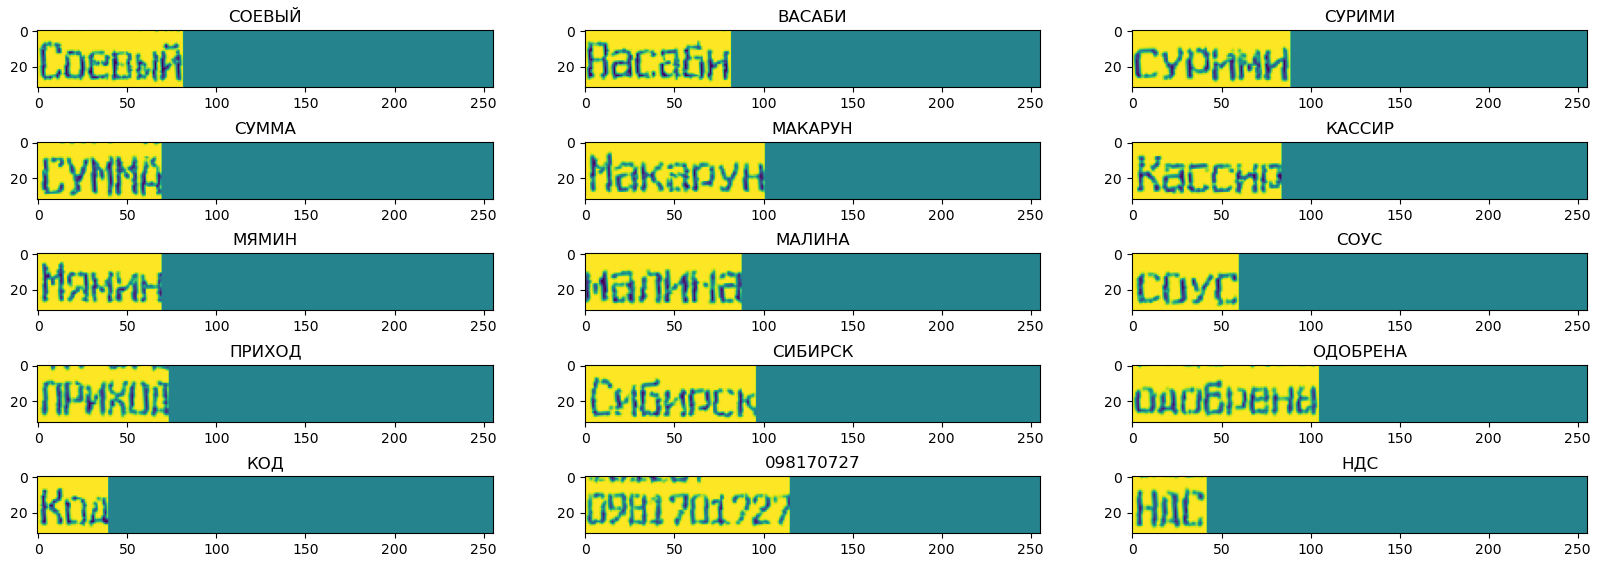

In [4]:
alphabets = ['ЁАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЬЫЪЭЮЯ 0123456789!@№%?()-=+.,/«»:;~""<>', 'ABCDEFGHIJKLMNOPRSTUVWXYZ 0123456789!@№%?()-=+.,/«»:;~""<>']

def get_words_images_from_formatted(data_dict):
    # returns [[crop_box, word, script_idx], ...]
    
    cutted_boxes = []
    assert len(data_dict['boxes']) == len(data_dict['words'])
    for i, box in enumerate(data_dict['boxes']):
        if len(data_dict['words'][i]) > 32 or len(data_dict['words'][i]) < 3:
            continue
        cropped_box = data_dict['image'].copy()[box[1]:box[3], box[0]:box[2]]
        cropped_box = prepare_segment_for_recognition(cropped_box).squeeze()

        if all(char in alphabets[0] for char in data_dict['words'][i].upper()):
            script_idx = 0
        elif all(char in alphabets[1] for char in data_dict['words'][i].upper()):
            script_idx = 1
        else:
            continue
        cutted_boxes.append([cropped_box, data_dict['words'][i].upper(), script_idx])

    return cutted_boxes

full_dataset = []
crnn_train_dataset = []
crnn_eval_dataset = []
for example in train_dataset:
    crnn_train_dataset.extend(get_words_images_from_formatted(example))
for example in val_dataset:
    crnn_eval_dataset.extend(get_words_images_from_formatted(example))

for example in train_dataset:
    full_dataset.extend(get_words_images_from_formatted(example))
for example in val_dataset:
    full_dataset.extend(get_words_images_from_formatted(example))

import random
random.shuffle(crnn_train_dataset)
random.shuffle(crnn_eval_dataset)
random.Random(59).shuffle(full_dataset)

crnn_random_train_dataset = full_dataset[:len(crnn_train_dataset)]
crnn_random_eval_dataset = full_dataset[len(crnn_train_dataset):]

fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(20, 7))
cropped_boxes_example = get_words_images_from_formatted(train_dataset[48])

print(len(crnn_train_dataset), len(crnn_eval_dataset))
print(len(crnn_random_train_dataset), len(crnn_random_eval_dataset))

for i in range(15):
    image = cropped_boxes_example[i][0].squeeze()
    word = cropped_boxes_example[i][1]
    axes[i // 3, i % 3].imshow(image, vmin=0, vmax=255)
    axes[i // 3, i % 3].set_title(f'{word}')

# Train

In [7]:
from torchmetrics.text import CharErrorRate
from torchmetrics.classification import MulticlassF1Score
from copy import deepcopy
from torchinfo import summary


epochs = 1000
batch_size = 128
early_stopping_patience = 59
img_size = (32, 256)
alphabets = ['ЁАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЬЫЪЭЮЯ 0123456789!@№%?()-=+.,/«»:;~""<>', 'ABCDEFGHIJKLMNOPRSTUVWXYZ 0123456789!@№%?()-=+.,/«»:;~""<>']

train_dataset = my_OCRDataset(crnn_random_train_dataset, img_size, alphabets, batch_size, num_steps=75)
val_dataset = my_OCRDataset(crnn_random_eval_dataset, img_size, alphabets, batch_size, num_steps=15)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=12)

#device = 'cpu'
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

model = MCRNN([len(a) for a in alphabets])
model.load_state_dict(torch.load('multilingual_crnn_2503m.pth', map_location=device))

optimizer = torch.optim.NAdam(model.parameters(), betas=(0.9, 0.999), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)

summary(model, input_size=(batch_size, 1, img_size[0], img_size[1]), device=device, depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
MCRNN                                    [128, 32, 67]             --
├─Sequential: 1-1                        [128, 256, 1, 32]         393,312
├─ScriptClassificationModel: 1-2         [128, 2]                  166,562
├─ModuleList: 1-3                        --                        2,139,782
Total params: 2,699,656
Trainable params: 2,699,656
Non-trainable params: 0
Total mult-adds (G): 13.46
Input size (MB): 4.19
Forward/backward pass size (MB): 664.67
Params size (MB): 10.80
Estimated Total Size (MB): 679.66

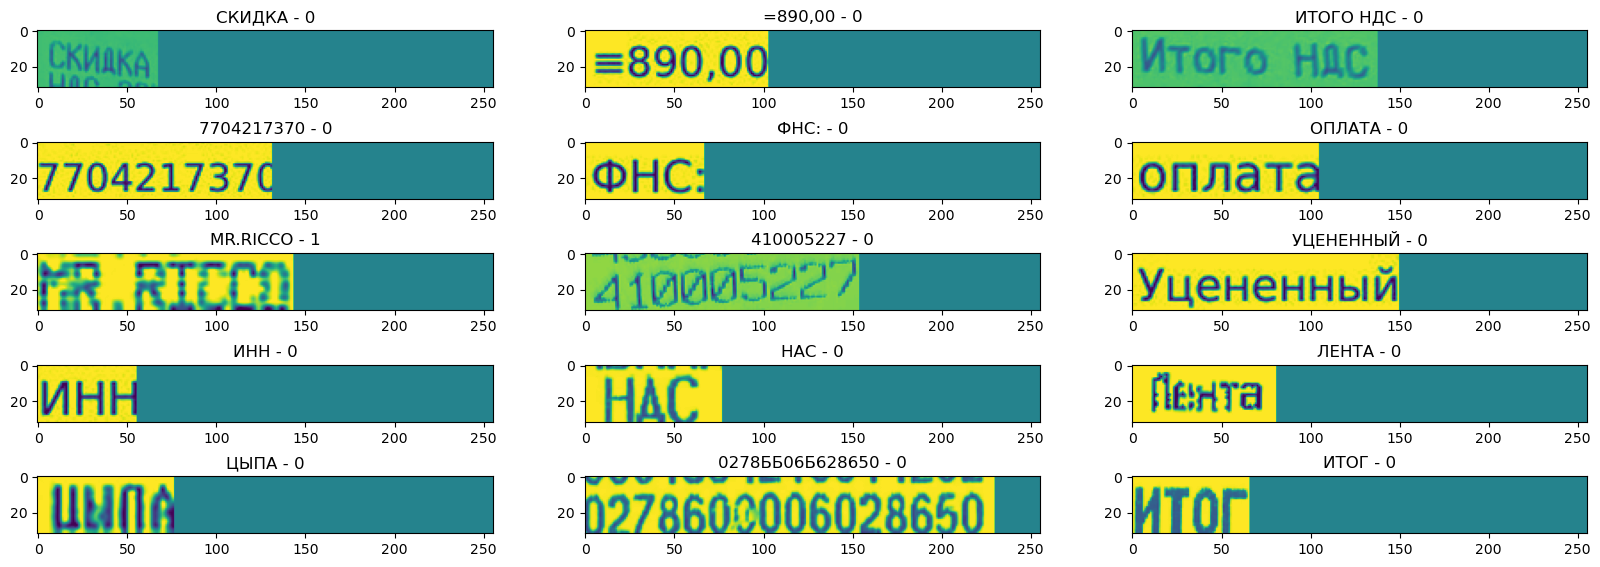

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(20, 7))

x, y_text, y_script = next(iter(train_loader))

for i in range(15):
    axes[i // 3, i % 3].imshow(x[i, 0].numpy(), vmin=0, vmax=1)
    axes[i // 3, i % 3].set_title(f'{train_dataset.decode_target(y_text[i], y_script[i])} - {y_script[i]}')

In [9]:
torch.autograd.set_detect_anomaly(True)

model = model.to(device)
model.train()

criterion = multilingual_loss
ctc_criterion = torch.nn.CTCLoss(blank=0, reduction='none', zero_infinity=True)
cer_metric = CharErrorRate()
script_det_f1 = MulticlassF1Score(num_classes=len(alphabets)).to(device)

best_model_state = None
best_model_val_loss = torch.finfo(torch.float32).max

history = list()

model = model.to(device)
model.train()

outer_pbar = tqdm(range(epochs), desc='Epoch: 0, val_loss: ..., val_cer: ..., val_f1: ...')

for epoch in outer_pbar:
    # while train_dataset.executor._work_queue.qsize() > 0:
    #     time.sleep(0.1)
    
    train_ctc_loss = 0
    train_script_loss = 0
    val_ctc_loss = 0
    val_script_loss = 0

    train_cer = 0
    train_f1 = 0
    val_cer = 0
    val_f1 = 0

    pbar = tqdm(train_loader, leave=False, desc=f'0/{len(train_loader)}, train_loss: ..., train_cer: ...')

    for i, (x, text_y, script_y) in enumerate(train_loader):
        x = x.to(device)
        text_y = text_y.to(device)
        script_y = script_y.to(device)

        optimizer.zero_grad()
        pred_text_logits, pred_script_probs = model(x)

        decoded_pred = [train_dataset.decode_pred(pred_text_logits[i], aidx) for i, aidx in zip(torch.arange(script_y.shape[0]), script_y)]
        decoded_target = [train_dataset.decode_target(t, aidx) for t, aidx in zip(text_y, script_y)]

        # Old Loss
        ctc_loss, script_loss = criterion(pred_text_logits, text_y, device, pred_script_probs, script_y, decoded_target)

        #log_logits: np.ndarray of shape (B, T, C)
        #targets: np.ndarray of shape (B, T,)
        #input_logits for torch ctc (T, B, C)
        t_pred_text_logits = torch.transpose(pred_text_logits, 0, 1)
        
        input_lengths = torch.full((t_pred_text_logits.shape[1],), t_pred_text_logits.shape[0]).to(device)
        target_lengths = torch.sum(text_y != 0, axis=1)
        
        torch_ctc_values = ctc_criterion(torch.log(t_pred_text_logits), text_y, input_lengths, target_lengths)
        
        # не угадал алфавит -> наказание константой
        torch_ctc_values[script_y != pred_script_probs.argmax(-1)] = 5.0

        torch_ctc_loss = torch_ctc_values.mean()
        
        train_ctc_loss += torch_ctc_loss.item()
        train_script_loss += script_loss.item()
        
        loss = torch_ctc_loss + script_loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        train_cer += cer_metric(decoded_pred, decoded_target).item()
        train_f1 += script_det_f1(pred_script_probs, script_y).item()

    #pbar.set_description(f'loss: {round((train_ctc_loss+train_script_loss)/(i+1), 4)}, train_cer: {round(train_cer/(i+1), 4)}, train_f1: {round(train_f1/(i+1), 4)}')
    #pbar.refresh()

    for i, (x, text_y, script_y) in enumerate(val_loader):
        x = x.to(device)
        text_y = text_y.to(device)
        script_y = script_y.to(device)
        
        with torch.no_grad():
            pred_text_logits, pred_script_probs = model(x)

        decoded_pred = [train_dataset.decode_pred(pred_text_logits[i], aidx) for i, aidx in zip(torch.arange(script_y.shape[0]), script_y)]
        decoded_target = [train_dataset.decode_target(t, aidx) for t, aidx in zip(text_y, script_y)]
        
        ctc_loss, script_loss = criterion(pred_text_logits, text_y, device, pred_script_probs, script_y, decoded_target)

        t_pred_text_logits = torch.transpose(pred_text_logits, 0, 1)
        
        input_lengths = torch.full((t_pred_text_logits.shape[1],), t_pred_text_logits.shape[0]).to(device)
        target_lengths = torch.sum(text_y != 0, axis=1)
        
        torch_ctc_values = ctc_criterion(torch.log(t_pred_text_logits), text_y, input_lengths, target_lengths)
        torch_ctc_values[script_y != pred_script_probs.argmax(-1)] = 5.0

        torch_ctc_loss = torch_ctc_values.mean()
        
        val_ctc_loss += torch_ctc_loss.item()
        val_script_loss += script_loss.item()

        val_cer += cer_metric(decoded_pred, decoded_target).item()
        val_f1 += script_det_f1(pred_script_probs, script_y).item()

    history.append([train_ctc_loss/len(train_loader), train_script_loss/len(train_loader), train_cer/len(train_loader), train_f1/len(train_loader), 
                    val_ctc_loss/len(val_loader), val_script_loss/len(val_loader), val_cer/len(val_loader), val_f1/len(val_loader)])

    if epoch > early_stopping_patience and (val_script_loss+val_ctc_loss) / len(val_loader) < np.array(history)[:, 4:6].sum(axis=1).min():
        best_model_state = model.state_dict()
    if epoch > early_stopping_patience and np.array(history)[:, 4:6].sum(axis=1).min() < np.array(history)[-early_stopping_patience:, 4:6].sum(axis=1).min():
        break

    outer_pbar.set_description(f'Epoch: {epoch}, val_loss: {round((val_ctc_loss + val_script_loss)/len(val_loader), 4)}, val_cer: {round(val_cer/len(val_loader), 4)}, val_f1: {round(val_f1/len(val_loader), 4)}')
if best_model_state is not None:
    model.load_state_dict(best_model_state)

history = np.array(history)

Epoch: 0, val_loss: ..., val_cer: ..., val_f1: ...:   0%|          | 0/1000 [00:00<?, ?it/s]
Epoch: 0, val_loss: 3.1471, val_cer: 0.1992, val_f1: 0.6977:   0%|          | 1/1000 [00:15<4:18:57, 15.55s/it]

0/82, train_loss: ..., train_cer: ...:   0%|          | 0/82 [00:00<?, ?it/s]
Epoch: 1, val_loss: 2.8092, val_cer: 0.1941, val_f1: 0.6824:   0%|          | 2/1000 [00:30<4:17:35, 15.49s/it]
0/82, train_loss: ..., train_cer: ...:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 2, val_loss: 2.6782, val_cer: 0.1696, val_f1: 0.7189:   0%|          | 3/1000 [00:46<4:17:15, 15.48s/it]

0/82, train_loss: ..., train_cer: ...:   0%|          | 0/82 [00:00<?, ?it/s]
Epoch: 3, val_loss: 2.5628, val_cer: 0.1593, val_f1: 0.7528:   0%|          | 4/1000 [01:01<4:16:22, 15.44s/it]
0/82, train_loss: ..., train_cer: ...:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 4, val_loss: 2.5281, val_cer: 0.133, val_f1: 0.7657:   0%|          | 5/1000 [01:17<4:14:58, 15.37s/it] 

0/82, train_loss: ..., train_c

In [10]:
min(np.array(history)[:, 6]) #the best so far 0.1258

0.1258552035218791

In [11]:
torch.save(model.state_dict(), '/home/vshishaev/mcrnn_engine/multilingual_crnn_2005m_2.pth')

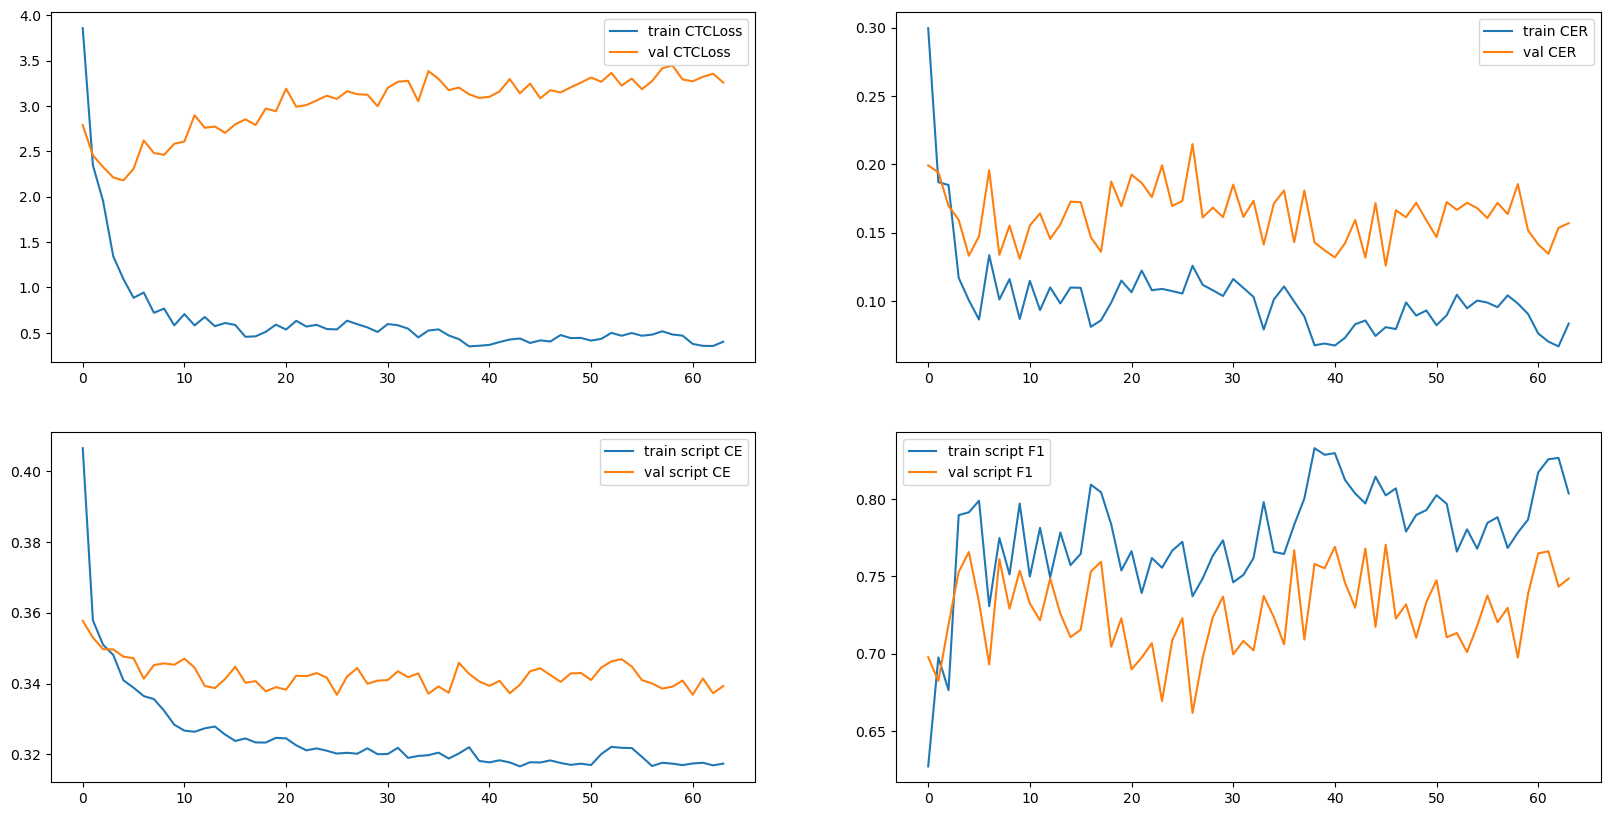

In [12]:
import matplotlib.pyplot as plt

history = np.array(history)

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 10))

axes[0, 0].plot(history[:, 0], label='train CTCLoss')
axes[0, 0].plot(history[:, 4], label='val CTCLoss')
# axes[0].set_ylim(min(train_loss_history)*0.75, max(train_loss_history[10:]))
axes[0, 0].legend()

axes[0, 1].plot(history[:, 2], label='train CER')
axes[0, 1].plot(history[:, 6], label='val CER')
# axes[1].set_ylim(min(train_cer_history)*0.75, max(train_cer_history[10:]))
axes[0, 1].legend()

axes[1, 0].plot(history[:, 1], label='train script CE')
axes[1, 0].plot(history[:, 5], label='val script CE')
axes[1, 0].legend()

axes[1, 1].plot(history[:, 3], label='train script F1')
axes[1, 1].plot(history[:, 7], label='val script F1')
axes[1, 1].legend()

In [13]:
model.load_state_dict(torch.load('/home/vshishaev/mcrnn_engine/multilingual_crnn_2005m_2.pth'))

<All keys matched successfully>

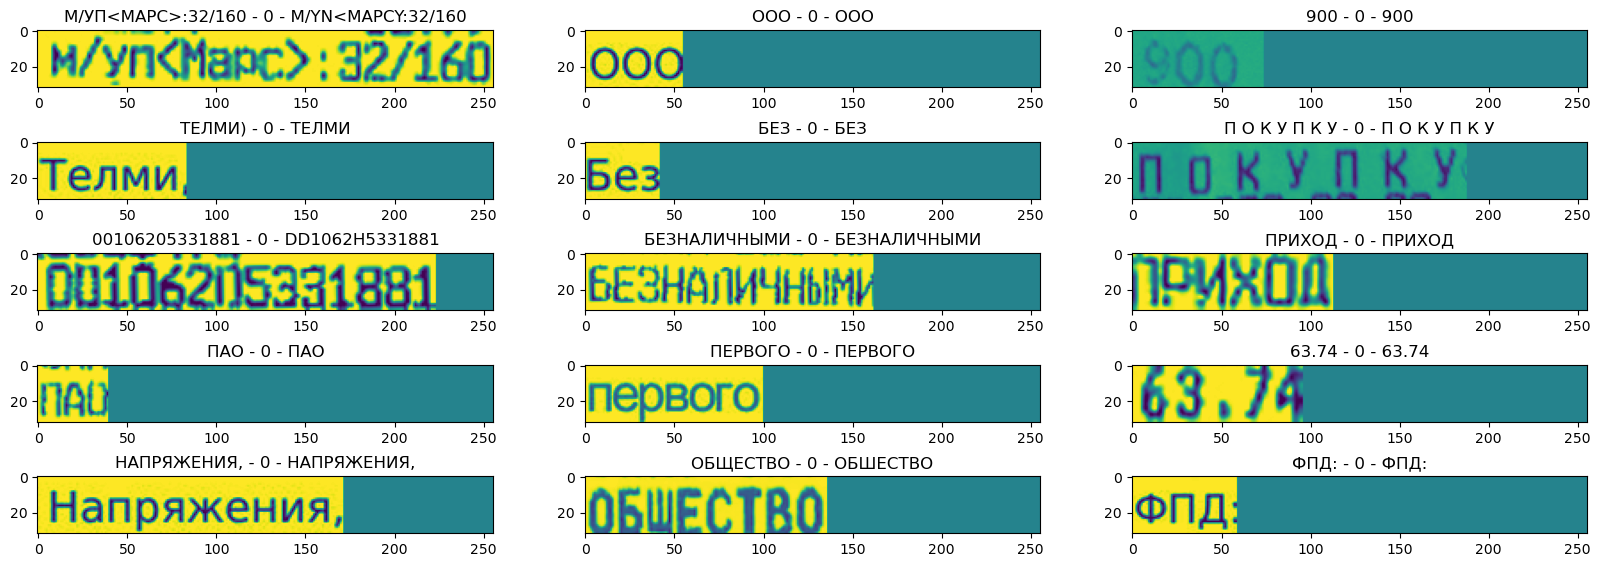

In [14]:
import matplotlib.pyplot as plt

def decode_texts(logits, alphabet, blank_idx):
    if blank_idx < 0:
        blank_idx = len(alphabet)
    best_path_indices = np.argmax(logits, axis=-1)
    best_chars_collapsed = [[alphabet[idx-(idx >= blank_idx)] for idx, _ in groupby(e) if idx != blank_idx and idx < len(alphabet)]
                            for e in best_path_indices]
    return [''.join(e) for e in best_chars_collapsed]

fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(20, 7))

x, y_text, y_script = next(iter(val_loader))

with torch.no_grad():
    y_pred_text, y_pred_script = model(x.to(device))

rus_indices = np.where(y_pred_script.argmax(-1).cpu().numpy() == 0)
eng_indices = np.where(y_pred_script.argmax(-1).cpu().numpy() == 1)

rus_texts = decode_texts(y_pred_text[rus_indices].cpu().numpy(), alphabets[0], blank_idx=0)
eng_texts = decode_texts(y_pred_text[eng_indices].cpu().numpy(), alphabets[1], blank_idx=0)

output = list()
ridx = 0
eidx = 0

for idx in y_pred_script.argmax(-1):
    if idx == 0:
        output.append(rus_texts[ridx])
        ridx += 1
    else:
        output.append(eng_texts[eidx])
        eidx += 1

for i in range(15):
    axes[i // 3, i % 3].imshow(x[i, 0].numpy(), vmin=0, vmax=1)
    axes[i // 3, i % 3].set_title(f'{val_dataset.decode_target(y_text[i], y_script[i])} - {y_script[i]} - {output[i]}')

In [ ]:
import os
import signal

os.kill(os.getpid(), signal.SIGTERM)